In [1]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
from utils import *
# from nn_for_fwi_80_16 import UNet_conditional,EMA
from nn_for_fwi_80_8_attention_3 import UNet_conditional,EMA  #depth=80 channel=8

import logging
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import math
from torch.utils import data
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device("cuda:0")

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

/home/wusl/anaconda3/envs/dl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def gaussian_kernel(size, sigma, num_channels, device):
    coords = torch.arange(size, dtype=torch.float32, device=device)
    coords -= (size - 1) / 2.0
    g = -(coords ** 2) / (2 * sigma ** 2)
    g = torch.exp(g)
    g /= g.sum()

    g_2d = g.unsqueeze(0) * g.unsqueeze(1)
    g_2d /= g_2d.sum() 

    gaussian_filter = g_2d.view(1, 1, size, size).repeat(num_channels, 1, 1, 1)
    return gaussian_filter

def _ssim(img1, img2, window, data_range, C1, C2):
    channels = img1.shape[1]
    window = window.to(img1.device)

    mu1 = F.conv2d(img1, window, padding='valid', groups=channels)
    mu2 = F.conv2d(img2, window, padding='valid', groups=channels)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding='valid', groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding='valid', groups=channels) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding='valid', groups=channels) - mu1_mu2

    luminance_map = (2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1).clamp(min=1e-8)
    contrast_structure_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2).clamp(min=1e-8)
    
    return luminance_map, contrast_structure_map

def msssim(img1, img2, window_size=11, data_range=1.0, size_average=True,
           scales=5, weights=None, sigma=1.5):
    if not img1.shape == img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    if img1.ndim != 4:
        raise ValueError("Input images must be 4D tensors (N, C, H, W).")

    num_channels = img1.shape[1]
    device = img1.device

    if weights is None:
        # 默认权重，根据 scales 数量调整
        if scales == 5:
            weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
        elif scales == 3:
            weights = [0.5, 0.3, 0.2] # 示例权重，总和为 1
        elif scales == 2: # 为 scales=2 提供一个示例权重
            weights = [0.7, 0.3] # 示例：给更精细的尺度更大的权重
        elif scales == 1: # 单尺度，权重自然是 1.0
            weights = [1.0]
        else:
            weights = [1.0 / scales] * scales
            print(f"Warning: Using uniform weights for {scales} scales as no specific weights are defined.")

    if len(weights) != scales:
        raise ValueError(f"Number of weights ({len(weights)}) must match number of scales ({scales}).")
    weights = torch.tensor(weights, dtype=torch.float32, device=device).view(1, scales)

    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2

    pad = (window_size - 1) // 2
    window = gaussian_kernel(window_size, sigma, num_channels, device)

    # 重要的尺寸检查：确保在所有尺度下图像维度都足够大
    current_h = img1.shape[2]
    current_w = img1.shape[3]
    
    for i in range(scales):
        # reflect padding 要求维度 > pad
        if current_h <= pad or current_w <= pad:
            raise ValueError(
                f"Image dimension ({current_h}x{current_w}) is too small for "
                f"reflect padding ({pad}) with window_size={window_size} at scale {i+1}/{scales}. "
                f"Consider reducing 'scales' or 'window_size', or increasing initial image size."
            )
        current_h //= 2
        current_w //= 2
            
    ssim_components_per_scale = []
    
    for i in range(scales):
        padded_img1 = F.pad(img1, (pad, pad, pad, pad), mode='reflect')
        padded_img2 = F.pad(img2, (pad, pad, pad, pad), mode='reflect')

        L_map, CS_map = _ssim(padded_img1, padded_img2, window, data_range, C1, C2)
        
        if i < scales - 1: # 非最粗尺度：使用 CS_map
            current_scale_component = CS_map.mean(dim=(-1, -2)).mean(dim=-1)
            ssim_components_per_scale.append(current_scale_component)
            
            img1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            img2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
        else: # 最粗尺度：使用 L_map
            current_scale_component = L_map.mean(dim=(-1, -2)).mean(dim=-1)
            ssim_components_per_scale.append(current_scale_component)

    ms_ssim_val = ssim_components_per_scale[-1].pow(weights[0, -1])

    for i in range(scales - 1):
        ms_ssim_val = ms_ssim_val * ssim_components_per_scale[i].pow(weights[0, i])
        
    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val

class MSSSIMLoss(nn.Module):
    def __init__(self, window_size=11, data_range=1.0, size_average=True,
                 scales=5, weights=None, sigma=1.5):
        super(MSSSIMLoss, self).__init__()
        self.window_size = window_size
        self.data_range = data_range
        self.size_average = size_average
        self.scales = scales
        self.weights = weights
        self.sigma = sigma

    def forward(self, img1, img2):
        ms_ssim_val = msssim(img1, img2,
                             window_size=self.window_size,
                             data_range=self.data_range,
                             size_average=self.size_average,
                             scales=self.scales,
                             weights=self.weights,
                             sigma=self.sigma)
        return 1.0 - ms_ssim_val

In [3]:
def chang_np_array_size(raw_data,resize_x=224,resize_z=224):
    resize = transforms.Resize((resize_x, resize_z))

    raw_data_img=Image.fromarray(raw_data)

    data_resize=resize(raw_data_img)
    data_resize=np.array(data_resize)
    return data_resize
def get_positional_encoding(seq_len, d_model):
    positional_encoding = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
            for i in range(0, d_model, 2):
                        positional_encoding[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                        positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
    return positional_encoding
def make_vp_net(data_raw,n_channel=16):
    xn,zn=data_raw.shape
    data_net=np.zeros([xn,n_channel,zn])
    consecutive_trace=n_channel
    for i in range(xn):
        try:
            if i < int(consecutive_trace/2):
        #         for j in range(i):
        #             vp_initial[i,j,:]=vp[0,:]
                data_net[i,:i,:]=data_raw[:i,:]
                data_net[i,i:consecutive_trace-i,:]=data_raw[i:consecutive_trace-i,:]

            elif i <= xn -int(consecutive_trace/2) :
                data_net[i,:,:]=data_raw[i-int(consecutive_trace/2):i+int(consecutive_trace/2),:]
            else:
                data_net[i,:,:]=data_raw[xn-consecutive_trace:,:]
                data_net[i,consecutive_trace-(xn-i):,:]=data_raw[i:,:]
        except:
            print(i)
    return data_net


import numpy as np
from scipy.interpolate import interp1d

def generate_migrated_data(resize_model, factor=4, fc=0.1):
    """
    Generate migrated seismic data from impedance model using convolution model.
    
    Parameters:
        resize_model (ndarray): 2D impedance model [traces, time_samples]
        factor (int): Upsampling factor (default=4)
        fc (float): Normalized wavelet frequency [cycles/sample] (default=0.1)
    
    Returns:
        migrated (ndarray): Synthetic seismic section [traces, time_samples]
    """
    # --- 1. Upsample impedance model ---
    orig_axis = np.arange(resize_model.shape[1])
    new_len = (resize_model.shape[1] - 1) * factor + 1
    new_axis = np.linspace(0, resize_model.shape[1]-1, new_len)
    
    model_up = np.zeros((resize_model.shape[0], new_len))
    for i in range(resize_model.shape[0]):
        f = interp1d(orig_axis, resize_model[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        model_up[i] = f(new_axis)

    # --- 2. Calculate reflectivities ---
    num = model_up[:, 1:] - model_up[:, :-1]
    den = model_up[:, 1:] + model_up[:, :-1]
    eps = 1e-9
    den = np.where(np.abs(den) < eps, eps, den)
    refl = num / den  # [traces, new_len-1]

    # --- 3. Build reflectivity series ---
    refl_series = np.zeros_like(model_up)
    refl_series[:, 1:] = refl

    # --- 4. Generate Ricker wavelet ---
    # Original domain wavelet (51 samples)
    wv_len_orig = 51
    center = (wv_len_orig-1)//2
    t_orig = np.arange(wv_len_orig) - center
    wavelet_orig = (1 - 2*(np.pi*fc*t_orig)**2) * np.exp(-(np.pi*fc*t_orig)**2)
    
    # Upsampled wavelet
    wv_up_axis = np.linspace(0, wv_len_orig-1, (wv_len_orig-1)*factor + 1)
    f_wavelet = interp1d(np.arange(wv_len_orig), wavelet_orig, 
                         kind='linear', bounds_error=False, fill_value=0)
    wavelet_up = f_wavelet(wv_up_axis)
    wavelet_up /= np.max(np.abs(wavelet_up))  # Normalize

    # --- 5. Convolve with wavelet ---
    synthetic = np.zeros_like(model_up)
    for i in range(model_up.shape[0]):
        synthetic[i] = np.convolve(refl_series[i], wavelet_up, mode='same')

    # --- 6. Downsample to original resolution ---
    migrated = np.zeros_like(resize_model)
    for i in range(synthetic.shape[0]):
        f = interp1d(new_axis, synthetic[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        migrated[i] = f(orig_axis)
    
    return migrated
import torch
import torch.nn.functional as F


def multi_migrated_data_cuda(impedance_model_3d, factor=4, fc=0.1, device='cuda'):
    image_3d_cuda = torch.zeros_like(impedance_model_3d, device=device)
    for i in range(impedance_model_3d.shape[0]):
        image_3d_cuda[i]=generate_migrated_data_cuda(impedance_model_3d[i], factor=factor, fc=fc)
    return image_3d_cuda
        


def generate_migrated_data_cuda(impedance_model, factor=4, fc=0.1, device='cuda'):

    
    """
    Generate migrated seismic data using a convolution model and a Ricker wavelet,
    with upsampling via `torch.nn.functional.interpolate`.
    
    Parameters:
        impedance_model (ndarray or tensor): 2D impedance model [traces, time_samples]
        factor (int): Upsampling factor (default=4)
        fc (float): Normalized central frequency of the Ricker wavelet [cycles/sample] (default=0.1)
        device (str): 'cuda' for GPU or 'cpu' for CPU (default='cuda')
    
    Returns:
        migrated (tensor): Synthetic seismic section [traces, time_samples]
    """
    
    # Convert input impedance model to torch tensor
    impedance_model = torch.tensor(impedance_model, dtype=torch.float32, device=device)

    # --- 1. Upsample impedance model ---
    orig_axis = torch.arange(impedance_model.shape[1], device=device).float().unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, original_length)
    new_len = (impedance_model.shape[1] - 1) * factor + 1
    new_axis = torch.linspace(0, impedance_model.shape[1] - 1, new_len, device=device).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, new_length)

    # Reshape impedance model to (batch_size, channels, length) for interpolation
    impedance_model_reshaped = impedance_model.unsqueeze(1)  # Shape: (traces, 1, time_samples)

    # Interpolate (upsample) the impedance model
    model_up = F.interpolate(impedance_model_reshaped, size=new_len, mode='linear', align_corners=True)

    # --- 2. Calculate reflectivities ---
    num = model_up[:, :, 1:] - model_up[:, :, :-1]
    den = model_up[:, :, 1:] + model_up[:, :, :-1]
    eps = 1e-9
    den = torch.where(torch.abs(den) < eps, eps, den)  # Avoid division by zero
    refl = num / den  # [traces, new_len-1]

    # --- 3. Build reflectivity series ---
    refl_series = torch.zeros_like(model_up)
    refl_series[:, :, 1:] = refl

    # --- 4. Generate Ricker wavelet ---
    wv_len_orig = 51
    center = (wv_len_orig - 1) // 2
    t_orig = torch.arange(wv_len_orig, device=device) - center
    wavelet_orig = (1 - 2 * (torch.pi * fc * t_orig) ** 2) * torch.exp(-(torch.pi * fc * t_orig) ** 2)

    # Upsampled wavelet using interpolation
    # Ensure wavelet is a 3D tensor: (1, 1, length)
    wavelet_orig = wavelet_orig.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, length)
#     print(wavelet_orig.shape,'wavelet_orig')
    wv_up_axis = torch.linspace(0, wv_len_orig - 1, (wv_len_orig - 1) * factor + 1, device=device).unsqueeze(0).unsqueeze(0)
    wavelet_up = F.interpolate(wavelet_orig, size=wv_up_axis.shape[-1], mode='linear', align_corners=True).squeeze(0).squeeze(0)

    wavelet_up = wavelet_up / torch.max(torch.abs(wavelet_up))  # Normalize wavelet

    # --- 5. Convolve with wavelet ---
    synthetic = torch.zeros_like(model_up, device=device)
    
    # Make sure the wavelet is in the correct shape for conv1d
    wavelet_up = wavelet_up.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kernel_size)

    for i in range(model_up.shape[0]):
        synthetic[i] = F.conv1d(refl_series[i].unsqueeze(0), wavelet_up, padding='same').squeeze(0)

    # --- 6. Downsample to original resolution ---
    migrated = torch.zeros_like(impedance_model, device=device)
    for i in range(synthetic.shape[0]):
        # Ensure the correct shape for interpolation (3D tensor: (1, 1, length))
        synthetic_i = synthetic[i].unsqueeze(0)  # Shape: (1, 1, length)
        # Now we can use F.interpolate
#         print(synthetic_i.shape,'synthetic_i')

        migrated[i] = F.interpolate(synthetic_i, size=impedance_model.shape[1], mode='linear', align_corners=True).squeeze(0).squeeze(0)

    return migrated


# fc is cycle per sample  e.g. 0.1 means the full cycle of the wavelet need 10 grid, and that means the wavenumber of  the wavelet is 10 grid *20m grid size=200m, so the freq =velocity 2000m/s/ wavenumber 200m  = 10 hz
# true freq = velocity/(grid_size/fc)

In [4]:
from matplotlib.pyplot import MaxNLocator
def plot_data_img_over(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=20
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::100]
    ticks_x=list(range(data.shape[0]))[::100]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=15)
    plt.ylabel('Depth $(km)$',fontsize=20)
    scale=20

    ytick=[float(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::25],ytick[::25],fontsize=15)
    plt.title('Distance $(km)$',fontsize=20)
    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()

    
def plot_field_cmp_over(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=20
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::100]
    ticks_x=list(range(data.shape[0]))[::100]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=15)
    
    scale=6.4

    ytick=[int(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::157],ytick[::157],fontsize=15)
    plt.title('Distance $(km)$',fontsize=20)
    plt.ylabel('Time $(s)$',fontsize=20)


    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()    

from matplotlib.pyplot import MaxNLocator
def plot_data_img(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=25
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::240]
    ticks_x=list(range(data.shape[0]))[::240]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=15)
    plt.ylabel('Depth $(km)$',fontsize=20)
    scale=75

    ytick=[int(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::16],ytick[::16],fontsize=15)
    plt.title('Distance $(km)$',fontsize=20)
    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()

    
def plot_field_cmp(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=25
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    plt.rcParams['figure.dpi'] = 300
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::160]
    ticks_x=list(range(data.shape[0]))[::160]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=15)
    
    scale=6.4

    ytick=[round(0.4+i*scale*0.001,1) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::157],ytick[::157],fontsize=15)
    plt.title('Distance $(km)$',fontsize=20)
    plt.ylabel('Time $(s)$',fontsize=20)


    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()       
def plot_field_cmp(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=25
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    plt.rcParams['figure.dpi'] = 300
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::160]
    ticks_x=list(range(data.shape[0]))[::160]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=15)
    
    scale=6.4

    ytick=[round(0.4+i*scale*0.001,1) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::157],ytick[::157],fontsize=15)
    plt.title('Distance $(km)$',fontsize=20)
    plt.ylabel('Time $(s)$',fontsize=20)


    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()        
def plot_result(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=20
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (18, 6)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
#     ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    
    xtick=[float(i*scale*0.001) for i in range(data.shape[0])][::50]
    ticks_x=list(range(data.shape[0]))[::50]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=10)
    
    
    ytick=[float(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::25],ytick[::25],fontsize=10)
    plt.title('Distance $(km)$',fontsize=12)
    plt.ylabel('Depth $(km)$',fontsize=12)
#     if savename is not None:
#         plt.savefig(savename+'.jpg')
#     plt.show()


def plot_result1(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=20
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (18, 6)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[float(i*scale*0.001) for i in range(data.shape[0])][::50]
    ticks_x=list(range(data.shape[0]))[::50]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=10)
    
    
    ytick=[float(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::25],ytick[::25],fontsize=10)
    
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
#     ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    
    plt.title('Distance $(km)$',fontsize=12)
#     plt.ylabel('Depth $(km)$',fontsize=20)



def plot_result_cmp(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=20
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (18, 6)
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[float(i*scale*0.001) for i in range(data.shape[0])][::50]
    ticks_x=list(range(data.shape[0]))[::50]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=10)
    
    scale=22
    ytick=[float(i*scale*0.001) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::25],ytick[::25],fontsize=10)
    
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
#     ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    
    plt.title('Distance $(km)$',fontsize=12)
#     plt.ylabel('Time $(s)$',fontsize=12)

In [5]:
def chang_np_array_size(raw_data,resize_x=224,resize_z=224):
    resize = transforms.Resize((resize_x, resize_z))

    raw_data_img=Image.fromarray(raw_data)

    data_resize=resize(raw_data_img)
    data_resize=np.array(data_resize)
    return data_resize
def get_positional_encoding(seq_len, d_model):
    positional_encoding = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
            for i in range(0, d_model, 2):
                        positional_encoding[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                        positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
    return positional_encoding
def make_vp_net(data_raw,n_channel=16):
    xn,zn=data_raw.shape
    data_net=np.zeros([xn,n_channel,zn])
    consecutive_trace=n_channel
    for i in range(xn):
        try:
            if i < int(consecutive_trace/2):
        #         for j in range(i):
        #             vp_initial[i,j,:]=vp[0,:]
                data_net[i,:i,:]=data_raw[:i,:]
                data_net[i,i:consecutive_trace-i,:]=data_raw[i:consecutive_trace-i,:]

            elif i <= xn -int(consecutive_trace/2) :
                data_net[i,:,:]=data_raw[i-int(consecutive_trace/2):i+int(consecutive_trace/2),:]
            else:
                data_net[i,:,:]=data_raw[xn-consecutive_trace:,:]
                data_net[i,consecutive_trace-(xn-i):,:]=data_raw[i:,:]
        except:
            print(i)
    return data_net

def make_cmp_net(seismic_data_raw,n_channel=16):
        NZ, n_cmp, Tn=seismic_data_raw.shape
        seismic_data = np.zeros([NZ, n_channel, n_cmp, Tn ])

        consecutive_trace=n_channel
        xn=NZ
        for i in range(xn):
            try:
                if i < int(consecutive_trace/2):
            #         for j in range(i):
            #             vp_initial[i,j,:]=vp[0,:]
                    seismic_data[i,:i,:]=seismic_data_raw[:i,:]
                    seismic_data[i,i:consecutive_trace-i,:]=seismic_data_raw[i:consecutive_trace-i,:]

                elif i <= xn -int(consecutive_trace/2) :
                    seismic_data[i,:,:]=seismic_data_raw[i-int(consecutive_trace/2):i+int(consecutive_trace/2),:]
                else:
                    seismic_data[i,:,:]=seismic_data_raw[xn-consecutive_trace:,:]
                    seismic_data[i,consecutive_trace-(xn-i):,:]=seismic_data_raw[i:,:]
            except:
                print(i)
        seismic_data = seismic_data.reshape(NZ, n_channel * (n_cmp), Tn )
        return seismic_data

import numpy as np
from scipy.interpolate import interp1d

def generate_migrated_data(resize_model, factor=4, fc=0.1):
    """
    Generate migrated seismic data from impedance model using convolution model.
    
    Parameters:
        resize_model (ndarray): 2D impedance model [traces, time_samples]
        factor (int): Upsampling factor (default=4)
        fc (float): Normalized wavelet frequency [cycles/sample] (default=0.1)
    
    Returns:
        migrated (ndarray): Synthetic seismic section [traces, time_samples]
    """
    # --- 1. Upsample impedance model ---
    orig_axis = np.arange(resize_model.shape[1])
    new_len = (resize_model.shape[1] - 1) * factor + 1
    new_axis = np.linspace(0, resize_model.shape[1]-1, new_len)
    
    model_up = np.zeros((resize_model.shape[0], new_len))
    for i in range(resize_model.shape[0]):
        f = interp1d(orig_axis, resize_model[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        model_up[i] = f(new_axis)

    # --- 2. Calculate reflectivities ---
    num = model_up[:, 1:] - model_up[:, :-1]
    den = model_up[:, 1:] + model_up[:, :-1]
    eps = 1e-9
    den = np.where(np.abs(den) < eps, eps, den)
    refl = num / den  # [traces, new_len-1]

    # --- 3. Build reflectivity series ---
    refl_series = np.zeros_like(model_up)
    refl_series[:, 1:] = refl

    # --- 4. Generate Ricker wavelet ---
    # Original domain wavelet (51 samples)
    wv_len_orig = 51
    center = (wv_len_orig-1)//2
    t_orig = np.arange(wv_len_orig) - center
    wavelet_orig = (1 - 2*(np.pi*fc*t_orig)**2) * np.exp(-(np.pi*fc*t_orig)**2)
    
    # Upsampled wavelet
    wv_up_axis = np.linspace(0, wv_len_orig-1, (wv_len_orig-1)*factor + 1)
    f_wavelet = interp1d(np.arange(wv_len_orig), wavelet_orig, 
                         kind='linear', bounds_error=False, fill_value=0)
    wavelet_up = f_wavelet(wv_up_axis)
    wavelet_up /= np.max(np.abs(wavelet_up))  # Normalize

    # --- 5. Convolve with wavelet ---
    synthetic = np.zeros_like(model_up)
    for i in range(model_up.shape[0]):
        synthetic[i] = np.convolve(refl_series[i], wavelet_up, mode='same')

    # --- 6. Downsample to original resolution ---
    migrated = np.zeros_like(resize_model)
    for i in range(synthetic.shape[0]):
        f = interp1d(new_axis, synthetic[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        migrated[i] = f(orig_axis)
    
    return migrated
def generate_migrated_data_from_flect(refl, factor=4, fc=0.1):
    """
    Generate migrated seismic data from impedance model using convolution model.
    
    Parameters:
        resize_model (ndarray): 2D impedance model [traces, time_samples]
        factor (int): Upsampling factor (default=4)
        fc (float): Normalized wavelet frequency [cycles/sample] (default=0.1)
    
    Returns:
        migrated (ndarray): Synthetic seismic section [traces, time_samples]
    """
    orig_axis = np.arange(refl.shape[1])
    new_len = (refl.shape[1] - 1) * factor + 1
    new_axis = np.linspace(0, refl.shape[1]-1, new_len)
    
    model_up = np.zeros((refl.shape[0], new_len))
    for i in range(refl.shape[0]):
        f = interp1d(orig_axis, refl[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        model_up[i] = f(new_axis)

    # --- 2. Calculate reflectivities ---


    # --- 3. Build reflectivity series ---
#     refl_series = np.zeros_like(model_up)
    refl_series = model_up

    # --- 4. Generate Ricker wavelet ---
    # Original domain wavelet (51 samples)
    wv_len_orig = 51
    center = (wv_len_orig-1)//2
    t_orig = np.arange(wv_len_orig) - center
    wavelet_orig = (1 - 2*(np.pi*fc*t_orig)**2) * np.exp(-(np.pi*fc*t_orig)**2)
    
    # Upsampled wavelet
    wv_up_axis = np.linspace(0, wv_len_orig-1, (wv_len_orig-1)*factor + 1)
    f_wavelet = interp1d(np.arange(wv_len_orig), wavelet_orig, 
                         kind='linear', bounds_error=False, fill_value=0)
    wavelet_up = f_wavelet(wv_up_axis)
    wavelet_up /= np.max(np.abs(wavelet_up))  # Normalize

    # --- 5. Convolve with wavelet ---
    synthetic = np.zeros_like(refl_series)
    for i in range(refl_series.shape[0]):
        synthetic[i] = np.convolve(refl_series[i], wavelet_up, mode='same')

    # --- 6. Downsample to original resolution ---
    migrated = np.zeros_like(refl)
    for i in range(synthetic.shape[0]):
        f = interp1d(new_axis, synthetic[i], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        migrated[i] = f(orig_axis)
    
    return migrated


In [6]:

class RFlow:
    def __init__(self, step=20,img_size=160, device=device):
        self.step = step

        self.img_size = img_size
        self.device = device


    def euler(self, x_t, v, dt):
        """ 使用欧拉方法计算下一个时间步长的值
            
        Args:
            x_t: 当前的值，维度为 [B, C, H, W]
            v: 当前的速度，维度为 [B, C, H, W]
            dt: 时间步长
        """
        x_t = x_t + v * dt

        return x_t

    # 路线
    # v1.2: reflow增加x_0的输入
    def create_flow(self, x_1, t, x_0=None):
        """ 使用x_t = t * x_1 + (1 - t) * x_0公式构建x_0到x_1的流

            X_1是原始图像 X_0是噪声图像（服从标准高斯分布）
            
        Args:
            x_1: 原始图像，维度为 [B, C, H, W]
            t: 一个标量，表示时间，时间范围为 [0, 1]，维度为 [B]
            x_0: 噪声图像，维度为 [B, C, H, W]，默认值为None
            
        Returns:
            x_t: 在时间t的图像，维度为 [B, C, H, W]
            x_0: 噪声图像，维度为 [B, C, H, W]
        
        """

        # 需要一个x0，x0服从高斯噪声
        if x_0 is None:
            x_0 = torch.randn_like(x_1).to(self.device)

        t = t[:, None, None, None].to(self.device)  # [B, 1, 1, 1]

        # 获得xt的值
        x_t = t * x_1 + (1 - t) * x_0

        return x_t, x_0

    # 司机
    def mse_loss(self, v, x_1, x_0):
        """ 计算RectifiedFlow的损失函数
        L = MSE(x_1 - x_0 - v(t))  匀速直线运动

        Args:
            v: 速度，维度为 [B, C, H, W]
            x_1: 原始图像，维度为 [B, C, H, W]
            x_0: 噪声图像，维度为 [B, C, H, W]
        """

        # 求loss函数，是一个MSE，最后维度是[B]

        loss = F.mse_loss(x_1 - x_0, v)
        # loss = torch.mean((x_1 - x_0 - v)**2)

        return loss
    
    
    
    
    def sample_for_gen(self,model=None,n=5,
        y=None,z=None,w=None,n_channel=None,
        cfg_scale=7.0,
        save_path='./results',
        save_noise_path=None,
        device='cuda'):
        
        """flow matching模型推理

        Args:
            checkpoint_path (str): 模型路径
            base_channels (int, optional): MiniUnet的基础通道数，默认值为16。
            step (int, optional): 采样步数（Euler方法的迭代次数），默认值为50。
            num_imgs (int, optional): 推理一次生成图片数量，默认值为5。
            y (torch.Tensor, optional): 条件生成中的条件，可以为数据标签（每一个标签是一个类别int型）或text文本（下一版本支持）,维度为[B]或[B, L]，其中B要么与num_imgs相等，要么为1（所有图像依照同一个条件生成）。 
            cfg_scale (float, optional): Classifier-free Guidance的缩放因子，默认值为7.0，y如果是None，无论这个值是几都是无条件生成。这个值越大，多样性下降，但生成图像更符合条件要求。这个值越小，多样性增加，但生成图像可能不符合条件要求。
            save_path (str, optional): 保存路径，默认值为'./results'。
            save_noise_path (str, optional): 保存噪声路径，默认值为None。
            device (str, optional): 推理设备，默认值为'cuda'。
        """

        os.makedirs(save_path, exist_ok=True)
        if save_noise_path is not None:
            os.makedirs(save_noise_path, exist_ok=True)



        with torch.no_grad():
        # 无条件或有条件生成图片
#                 print(f'Generating {i}th image...')
                # Euler法间隔
                dt = 1.0 / self.step

                # 初始的x_t就是x_0，标准高斯噪声
                x_t = torch.randn((n, 2, n_channel, self.img_size)).to(self.device)
                noise = x_t.detach().cpu().numpy()

                # 提取第i个图像的标签条件y_i
#                 if y is not None:
#                     y_i = y.unsqueeze(0)
                y_i = y.to(device)
                z_i = z.to(device)
                w_i = w.to(device)

                for j in range(self.step):
#                     if j % 10 == 0:
#                         print(f'Generating {i}th image, step {j}...')
                    t = torch.ones(n)*j * dt
                    t = t.to(device)
#                     if y is not None:
#     #                     # classifier-free guidance需要同时预测有条件和无条件的输出
#     #                     # 利用CFG的公式：x = x_uncond + cfg_scale * (x_cond - x_uncond)
#     #                     # 为什么用score推导的公式放到预测向量场v的情形可以直接用？ SDE ODE
#                         v_pred_uncond = model(x=x_t, t=t)
#                         v_pred_cond = model(x=x_t, t=t, y=y_i,w=w_i)
#                         v_pred = v_pred_uncond + cfg_scale * (v_pred_cond -
#                                                               v_pred_uncond)
#                     else:
#                         v_pred = model(x=x_t, t=t)
                    
                    v_pred = model(x=x_t, t=t, y=y_i,z=z_i,w=w_i)
        
            
                    # 使用Euler法计算下一个时间的x_t
                    x_t = rf.euler(x_t, v_pred, dt)

                # 最后一步的x_t就是生成的图片
                # 先去掉batch维度
    #             x_t = x_t[0]
        return x_t



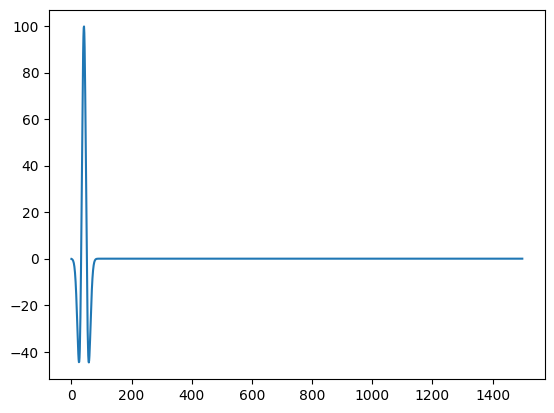

83


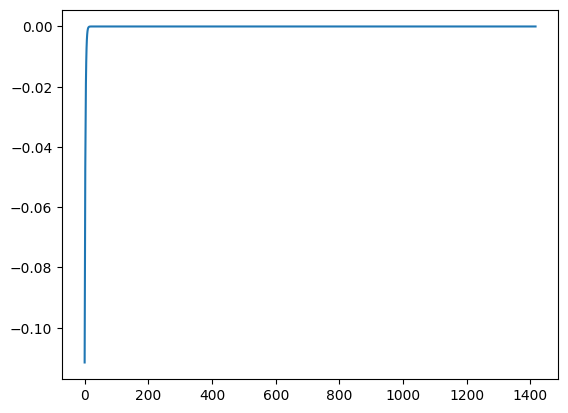

91


In [7]:
import math
pi = math.pi
def ricker(dt, favg, Tn):
    w = np.zeros([Tn])
    for k in range(Tn):
        w[k] = 100 * (1 - 2 * ((pi * favg * (k * dt - 1 / favg)) ** 2)) * np.exp(
            -1.0 * ((pi * favg * (k * dt - 1 / favg)) ** 2))
    # print(wavelet)
    return w
dt=0.002
favg=12
Tn=1500
wavelet_check = ricker(dt, favg, Tn)
plt.plot(wavelet_check)
plt.show()


zhouqi=2/(favg)
print(int(zhouqi/dt))
plt.plot(wavelet_check[int(zhouqi/dt):])
plt.show()

dx_2=2.5*20
t_2=dx_2/3000
print(int(zhouqi/dt+t_2/dt))

In [10]:

NX=70
n_cmp_raw = 2

Tn = 1500  # 时间长度
n_channel_raw = 8  #{}_cmp_2
n_channel=n_channel_raw


img_size=64

pao_interval=5

DX=20

# wavelet_freq=30

n_cmp = 2
smooth_sigma=2
wavelet_freq=30


resize_x=n_channel*n_cmp

import scipy.ndimage
from scipy.ndimage import gaussian_filter
iter_i=200


def make_model_big(model_0,resize_x=100,resize_z=140):
    vp_i_reshape2 = ndimage.zoom(model_0, 3, order=4)  # order=3为双三次插值
    vp_i_reshape=chang_np_array_size(vp_i_reshape2,resize_x=resize_x,resize_z=resize_z)
    smoothed = anisotropic_diffusion(vp_i_reshape, kappa=30, iterations=15)
    return smoothed

vp_arr=[]
rtm_arr=[]
cmp_arr=[]
rtm0_arr=[]
vp0_arr=[]

In [11]:
"""field data test"""

'field data test'

In [12]:
field_root_dir="/data/wsl/jinshan_data/"
DX=20
DZ=25
NZ=1260
Tn=650
n_channel=8
n_cmp=2
xn=NZ
NR=NZ
cmp_8_data=np.fromfile(field_root_dir+"filed_cmp_1260_2_650_cut", dtype=np.float32).reshape(NZ,n_cmp,Tn)
seismic_data_raw = cmp_8_data.copy()

# seismic_data = np.zeros([NZ, n_channel, n_cmp, Tn + NS + NR])
seismic_data = np.zeros([NZ, n_channel, n_cmp, Tn ])

consecutive_trace=n_channel
for i in range(xn):
    try:
        if i < int(consecutive_trace/2):
    #         for j in range(i):
    #             vp_initial[i,j,:]=vp[0,:]
            seismic_data[i,:i,:]=seismic_data_raw[:i,:]
            seismic_data[i,i:consecutive_trace-i,:]=seismic_data_raw[i:consecutive_trace-i,:]

        elif i <= xn -int(consecutive_trace/2) :
            seismic_data[i,:,:]=seismic_data_raw[i-int(consecutive_trace/2):i+int(consecutive_trace/2),:]
        else:
            seismic_data[i,:,:]=seismic_data_raw[xn-consecutive_trace:,:]
            seismic_data[i,consecutive_trace-(xn-i):,:]=seismic_data_raw[i:,:]
    except:
        print(i)



seismic_data = seismic_data.reshape(NZ, n_channel * (n_cmp), Tn )

In [25]:
field_root_dir="/data/wsl/jinshan_data/"

NZ=1260
NX=64
n_cmp = 2
n_channel = 8  #{}_cmp_2
NR=1260
# Tn = 1001  # 时间长度
Tn=730-80

nz=NZ
img_size=64

vp_arr=[]
rtm_arr=[]
cmp_arr=[]
rtm0_arr=[]


cut_model=195
vp_real_i = np.fromfile(field_root_dir+"vel.bin", dtype=np.float32).reshape([1360, 250])




vp_real_i_resize=chang_np_array_size(vp_real_i[70:-30,:cut_model],resize_x=NZ,resize_z=NX)





vp_r_mean=np.mean(vp_real_i_resize)
vp_r_std=np.std(vp_real_i_resize)

vp_net_i=make_vp_net(vp_real_i_resize,n_channel=n_channel)

 
cmp_i=np.load(field_root_dir+"cmp_net.npy")    


rtm_i_resize=np.load(field_root_dir+"rtm_net.npy")



rtm_i_resize=chang_np_array_size(rtm_i_resize,resize_x=NZ,resize_z=img_size)

rtm_net_i=make_vp_net(rtm_i_resize,n_channel=n_channel)



rtm_i0 = generate_migrated_data(vp_real_i_resize, factor=4, fc=(DX/(3000/wavelet_freq)))# true freq = velocity/(grid_size/fc) 调节最后一个数字为 freq 目前是30hz
rtm_i0=chang_np_array_size(rtm_i0,resize_x=NZ,resize_z=img_size)
rtm_net_i0=make_vp_net(rtm_i0,n_channel=n_channel)
rtm0_arr.append(rtm_net_i0[:])




vp_arr.append(vp_net_i)
rtm_arr.append(rtm_net_i)
cmp_arr.append(cmp_i)

vp_arr=np.array(vp_arr)
rtm_arr=np.array(rtm_arr)
cmp_arr=np.array(cmp_arr)
rtm0_arr=np.array(rtm0_arr)

rtm0_arr=np.concatenate(rtm0_arr,axis=0)

vp_arr=np.concatenate(vp_arr,axis=0)
rtm_arr=np.concatenate(rtm_arr,axis=0)
cmp_arr=np.concatenate(cmp_arr,axis=0)



vp_mean = np.mean(vp_arr,axis=(0,-1), keepdims=True)
vp_std = np.std(vp_arr,axis=(0,-1), keepdims=True)
vp_arr = (vp_arr - vp_mean) / (vp_std+1e-12)



rtm_mean = np.mean(rtm_arr,axis=(0,-1), keepdims=True)
rtm_std = np.std(rtm_arr,axis=(0,-1), keepdims=True)
rtm_net = (rtm_arr - rtm_mean) / (rtm_std+1e-12)

cmp_net=make_cmp_net(cmp_arr,n_channel=8)


cmp_mean = np.mean(cmp_net,axis=(0,-1), keepdims=True)
cmp_std = np.std(cmp_net,axis=(0,-1), keepdims=True)
cmp_net = (cmp_net - cmp_mean) / (cmp_std+1e-12)

rtm0_mean = np.mean(rtm0_arr,axis=(0,-1), keepdims=True)
rtm0_std = np.std(rtm0_arr,axis=(0,-1), keepdims=True)
rtm0_net = (rtm0_arr - rtm0_mean) / (rtm0_std+1e-12)

print(vp_arr.shape)
print(cmp_net.shape)
print(rtm_net.shape)
print(rtm0_net.shape)


(1260, 8, 64)
(1260, 16, 500)
(1260, 8, 64)
(1260, 8, 64)


In [26]:




NR=vp_arr.shape[0]



resize_x=n_channel*n_cmp
resize_z=256
# pos_encoding = get_positional_encoding(NR, resize_z)
# # print(pos_encoding.shape)
resized_seismic_data=np.zeros([NR,3,resize_x,resize_z]) # 0:cmp 1:vel_smooth
for i in range(NR):
    resized_seismic_data[i,0]=chang_np_array_size(cmp_net[i],resize_x=int(resize_x),resize_z=resize_z)
    resized_seismic_data[i,1]=chang_np_array_size(vp_arr[i],resize_x=int(resize_x),resize_z=resize_z)
    resized_seismic_data[i,2]=chang_np_array_size(rtm0_net[i],resize_x=int(resize_x),resize_z=resize_z)

    




nx=NR
print(nx)


input_data=rtm_net.reshape([nx,1,n_channel,img_size])

# print(input_data)
print(resized_seismic_data.shape)




1260
(1260, 3, 16, 256)


In [24]:
# 
from nn_for_fwi_80_8_attention_3 import UNet_conditional,EMA



batch_size = 128
image_size = img_size
device = "cuda"


lr = 3e-4
run_name = "openfwi_fault_curve_flat_3conditon_f{}_channel8_small_cmp_sigma{}_pred2_v2_big_loss2".format(wavelet_freq,smooth_sigma) # vp->rtm loss 权重更大

# 
setup_logging(run_name)
device = device









model = UNet_conditional(c_in=2, c_out=2,number_traces=resize_x).to(device)
ckpt = torch.load("./models/"+run_name+"/ckpt.pt")
model.load_state_dict(ckpt)
# 

optimizer = optim.AdamW(model.parameters(), lr=lr)
mse = nn.MSELoss()


rf = RFlow(step=20,img_size=image_size, device=device)


logger = SummaryWriter(os.path.join("runs", run_name))
l = nx
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

from torch.optim.lr_scheduler import StepLR
lr_adjust_epoch=50
scheduler = StepLR(optimizer, step_size=lr_adjust_epoch, gamma=0.1)






train_rtm_data=torch.tensor(input_data).float()
train_seismic_data=torch.tensor(resized_seismic_data).float()

/tmp/ipykernel_155316/490418889.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seismic_data=torch.tensor(resized_seismic_data).float()


In [16]:
def plot_field_cmp(data,savename=None,colorbar=None,cmap='jet',vmin=None,vmax=None):
    
    scale=25
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (8, 3)
    plt.rcParams['figure.dpi'] = 300
    if (vmin and vmax):
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmin :
        _,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    elif vmax:
        vmin,_=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
    else:
        vmin,vmax=np.percentile(data,[0,100])
        plt.imshow(data.T,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
        
       
    if colorbar is not None:
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
#     cb.set_label('Velocity $(m/s)$', size=20)
#     cb.set_label('速度 $(m/s)$', size=20)

    ax=plt.gca()
    ax.xaxis.set_ticks_position('top')
    
    
    xtick=[int(i*scale*0.001) for i in range(data.shape[0])][::160]
    ticks_x=list(range(data.shape[0]))[::160]
#     xtick.append(int(data.shape[0]*scale*0.001))
#     ticks_x.append(data.shape[0]-1)
    plt.xticks(ticks_x,xtick,fontsize=10)
    
    scale=6.4

    ytick=[round(0.4+i*scale*0.001,1) for i in range(data.shape[1])]
    plt.yticks(list(range(data.shape[1]))[::157],ytick[::157],fontsize=10)
    plt.title('Distance $(km)$',fontsize=12)
    plt.ylabel('Time $(s)$',fontsize=12)


    if savename is not None:
        plt.savefig(savename+'.jpg')
    plt.show()        

In [17]:
"""多道预测叠加  + 卡尔曼滤波 优化"""
import time 
rf_pred = RFlow(step=5,img_size=image_size, device=device)

cal_n_result=10
result_10=np.zeros([cal_n_result,nx,img_size])
resized_seismic_data=torch.tensor(resized_seismic_data).float()

# resized_seismic_data_cuda = resized_seismic_data.to(device)

# sampled_images = diffusion.sample(ema_model, n=100,labels=seismic_data[20:120], cfg_scale=9)
# factor_x=[0.1, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0.1]
# factor_x=[0.04, 0.06, 0.1, 0.3, 0.3, 0.1, 0.06, 0.04]  ##尝试根据 卡尔曼滤波 分配权重因子
factor_x=[1/n_channel for _ in range(n_channel)]*n_channel*n_channel



# n_trace=int((number_end-number_start)/number_interval)
# n_trace=10
# process_batch=int(NZ/n_trace)

process_batch=100+n_channel*2

n_trace=8

resized_seismic_data_group=np.zeros([n_trace,process_batch,3,resize_x,resize_z])

j=0
for i in range(0,n_trace*100,100):
    if j==0:
        resized_seismic_data_group[j]=resized_seismic_data[j:j+100+n_channel*2]

    else:
        resized_seismic_data_group[j]=resized_seismic_data[j*100-n_channel:j*100+100+n_channel]
    j+=1
resized_seismic_data_group_cuda = torch.tensor(resized_seismic_data_group.reshape([-1,3,resize_x,resize_z])).float().to(device)


result_inv_temp_n10=np.zeros([cal_n_result,n_trace,process_batch,n_channel,img_size])
result_inv_temp_n10_2=np.zeros([cal_n_result,n_trace,process_batch,n_channel,img_size])




nx=process_batch*n_trace
start_t=time.time()
for n in range(cal_n_result):
    

    result_inv=np.zeros([nx,n_channel,img_size])
    result_inv_2=np.zeros([nx,n_channel,img_size])
    
    for i in range(0,nx,process_batch):
        print("invert for {} to {}".format(i,i+process_batch))
        resized_seismic_data_cuda = resized_seismic_data[i:i+process_batch].to(device)

#         sampled_images = rf.sample_for_gen(model, n=process_batch,y=resized_seismic_data_cuda[:,0],z=resized_seismic_data_cuda[:,1])
        
        sampled_images = rf_pred.sample_for_gen(model, n=process_batch,y=resized_seismic_data_group_cuda[i:i+process_batch,0],z=resized_seismic_data_group_cuda[i:i+process_batch,1],w=resized_seismic_data_group_cuda[i:i+process_batch,2],n_channel=n_channel)

#         temp=np.mean(sampled_images.detach().cpu().numpy()[:,0,:,:],axis=1)
        temp=sampled_images.detach().cpu().numpy()[:,0,:,:]*(rtm_std+1e-12)+rtm_mean

#         temp2=sampled_images.detach().cpu().numpy()[:,1,:,:]*(vp_max-vp_min+1e-6)+vp_min

        temp2=sampled_images.detach().cpu().numpy()[:,1,:,:]*(vp_std+1e-12)+vp_mean

        result_inv[i:i+process_batch]=temp.reshape(-1,n_channel,img_size)
        result_inv_2[i:i+process_batch]=temp2.reshape(-1,n_channel,img_size)




    result_inv_temp=result_inv.reshape([n_trace,process_batch,n_channel,img_size])
    
    result_inv_temp_n10[n]=result_inv_temp
    result_inv_temp_n10_2[n]=result_inv_2.reshape([n_trace,process_batch,n_channel,img_size])
print(result_inv_temp_n10_2.mean())
# print(result_inv_temp_n10.shape)
print("time consuming is ",time.time()-start_t)
result_inv_temp_mean=np.mean(result_inv_temp_n10,axis=0)    
result_inv_temp_std=np.std(result_inv_temp_n10,axis=0)    
# print(result_inv_temp_mean.shape)
result_inv_temp_var=np.power(result_inv_temp_std,2)


final_result_mean=np.zeros([n_trace,process_batch,img_size])
final_result_std=np.zeros([n_trace,process_batch,img_size])


result_inv_temp_mean_2=np.mean(result_inv_temp_n10_2,axis=0)    
result_inv_temp_std_2=np.std(result_inv_temp_n10_2,axis=0)    
# print(result_inv_temp_mean.shape)
result_inv_temp_var_2=np.power(result_inv_temp_std_2,2)


final_result_mean2=np.zeros([n_trace,process_batch,img_size])
final_result_std2=np.zeros([n_trace,process_batch,img_size])



for line_i in range(result_inv_temp_var.shape[0]):
    combine_result=np.zeros([process_batch,img_size])
    combine_var=np.zeros([process_batch,img_size])

    test_line=result_inv_temp_mean[line_i]
    test_line_var=result_inv_temp_var[line_i]
    combine_result2=np.zeros([process_batch,img_size])
    combine_var2=np.zeros([process_batch,img_size])

    test_line2=result_inv_temp_mean_2[line_i]
    test_line_var2=result_inv_temp_var_2[line_i]
    for p_i in range(int(n_channel/2),result_inv_temp_var.shape[1]-int(n_channel/2)):
        factor_fenzi=[]
        for jj in range(n_channel):
            factor_fenzi.append(1/(test_line_var[p_i-int(n_channel/2)+jj,n_channel-jj-1]+1e-13))
            
            


        factor_fenzi=np.array(factor_fenzi)
#         print(factor_fenzi.shape)
        sum_factor_fenzi=np.sum(factor_fenzi,axis=0)
#         print(sum_factor_fenzi.shape)
        factor_fenzi=factor_fenzi/sum_factor_fenzi
    
    
#         for jj in range(8):
#             factor_fenzi[jj]=(factor_fenzi[jj])/sum_factor_fenzi

#         print(factor_fenzi.shape)
#         print(factor_fenzi[:,20])

#         print(np.sum(factor_fenzi,axis=0))
        for jj in range(n_channel):
            combine_result[p_i]+=factor_x[jj]*factor_fenzi[jj]*test_line[p_i-int(n_channel/2)+jj,n_channel-jj-1]
            combine_var[p_i]+=((factor_x[jj]*factor_fenzi[jj])** 2)*test_line_var[p_i-int(n_channel/2)+jj,n_channel-jj-1]##卡尔曼滤波因子*地质约束因子
            combine_result2[p_i]+=factor_x[jj]*factor_fenzi[jj]*test_line2[p_i-int(n_channel/2)+jj,n_channel-jj-1]*n_channel
            combine_var2[p_i]+=((factor_x[jj]*factor_fenzi[jj])** 2)*test_line_var2[p_i-int(n_channel/2)+jj,n_channel-jj-1]*n_channel##卡尔曼滤波因子*地质约束因子
#             combine_result2[p_i]+=factor_x[jj]*test_line2[p_i-int(n_channel/2)+jj,n_channel-jj-1]
#             combine_var2[p_i]+=((factor_x[jj])** 2)*test_line_var2[p_i-int(n_channel/2)+jj,n_channel-jj-1]##卡尔曼滤波因子*地质约束因子
             
    final_result_mean[line_i]=combine_result
    final_result_std[line_i]= np.sqrt(combine_var)
    final_result_mean2[line_i]=combine_result2
    final_result_std2[line_i]= np.sqrt(combine_var2)
    
final_result_mean=final_result_mean.reshape([-1,img_size])

final_result_std=final_result_std.reshape([-1,img_size])      
final_result_mean2=final_result_mean2.reshape([-1,img_size])

final_result_std2=final_result_std2.reshape([-1,img_size])
print(final_result_mean2.mean())
print(final_result_mean2.std())


invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696
invert for 696 to 812
invert for 812 to 928
invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696
invert for 696 to 812
invert for 812 to 928
invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696
invert for 696 to 812
invert for 812 to 928
invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696
invert for 696 to 812
invert for 812 to 928
invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696
invert for 696 to 812
invert for 812 to 928
invert for 0 to 116
invert for 116 to 232
invert for 232 to 348
invert for 348 to 464
invert for 464 to 580
invert for 580 to 696


In [18]:

final_result_mean=final_result_mean.reshape([n_trace,process_batch,img_size])
# print(final_result_mean.shape)
final_result_std=final_result_std.reshape([n_trace,process_batch,img_size])
full_profile_mean=np.zeros([n_trace*100,img_size])
full_profile_std=np.zeros([n_trace*100,img_size])

full_profile_mean_mean=np.mean(full_profile_mean,axis=(0,-1),keepdims=True)
full_profile_mean_std=np.std(full_profile_mean,axis=(0,-1),keepdims=True)

full_profile_mean=(full_profile_mean-full_profile_mean_mean)/full_profile_mean_std

j=0
for i in range(0,n_trace*100,100):
    if j==0:
        full_profile_mean[j:j+100]=final_result_mean[j,:100]
        full_profile_std[j:j+100]=final_result_std[j,:100]

    else:
        full_profile_mean[j*100:j*100+100]=final_result_mean[j,n_channel:-n_channel]
        full_profile_std[j*100:j*100+100]=final_result_std[j,n_channel:-n_channel]

    j+=1
    
    

final_result_mean2=final_result_mean2.reshape([n_trace,process_batch,img_size])
# print(final_result_mean.shape)
final_result_std2=final_result_std2.reshape([n_trace,process_batch,img_size])
full_profile_mean2=np.zeros([n_trace*100,img_size])
full_profile_std2=np.zeros([n_trace*100,img_size])







j=0
for i in range(0,n_trace*100,100):
    if j==0:
        full_profile_mean2[j:j+100]=final_result_mean2[j,:100]
        full_profile_std2[j:j+100]=final_result_std2[j,:100]

    else:
        full_profile_mean2[j*100:j*100+100]=final_result_mean2[j,n_channel:-n_channel]
        full_profile_std2[j*100:j*100+100]=final_result_std2[j,n_channel:-n_channel]

    j+=1    
    


/tmp/ipykernel_155316/2005383994.py:10: RuntimeWarning: invalid value encountered in divide
  full_profile_mean=(full_profile_mean-full_profile_mean_mean)/full_profile_mean_std


/tmp/ipykernel_155316/1466492937.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  rtm_i_resize_filter=scipy.ndimage.filters.gaussian_filter(rtm_i_resize, sigma=1)


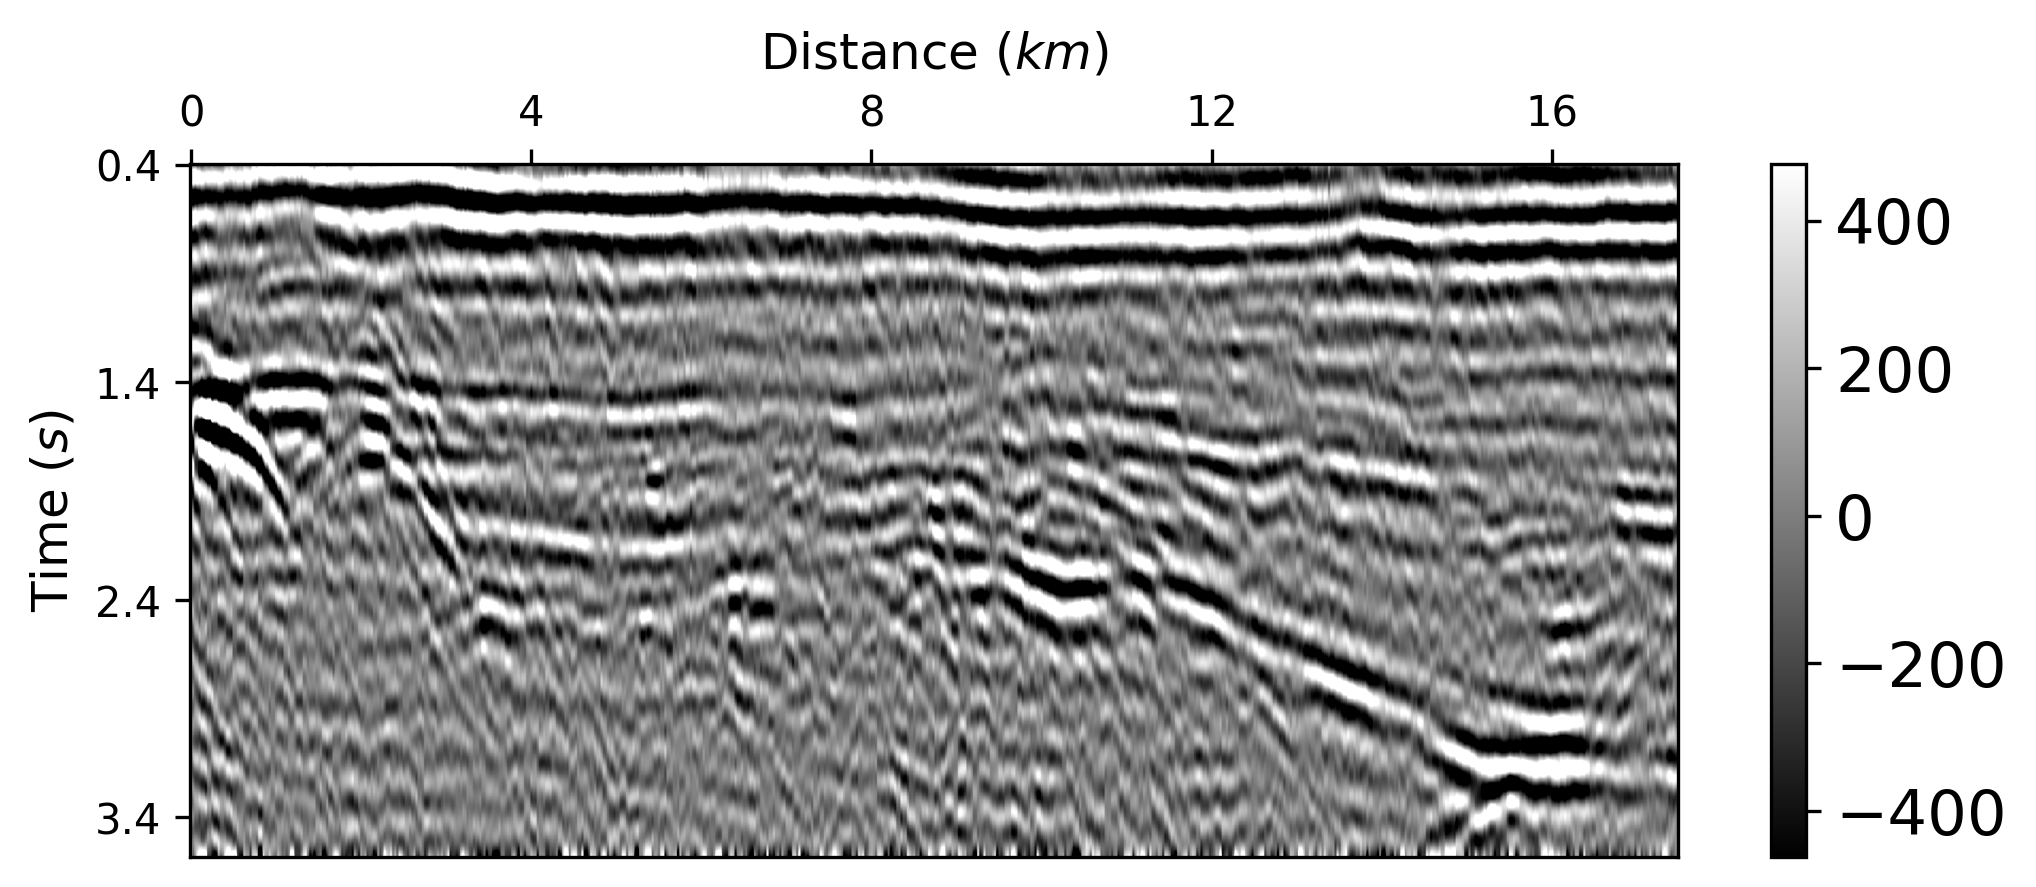

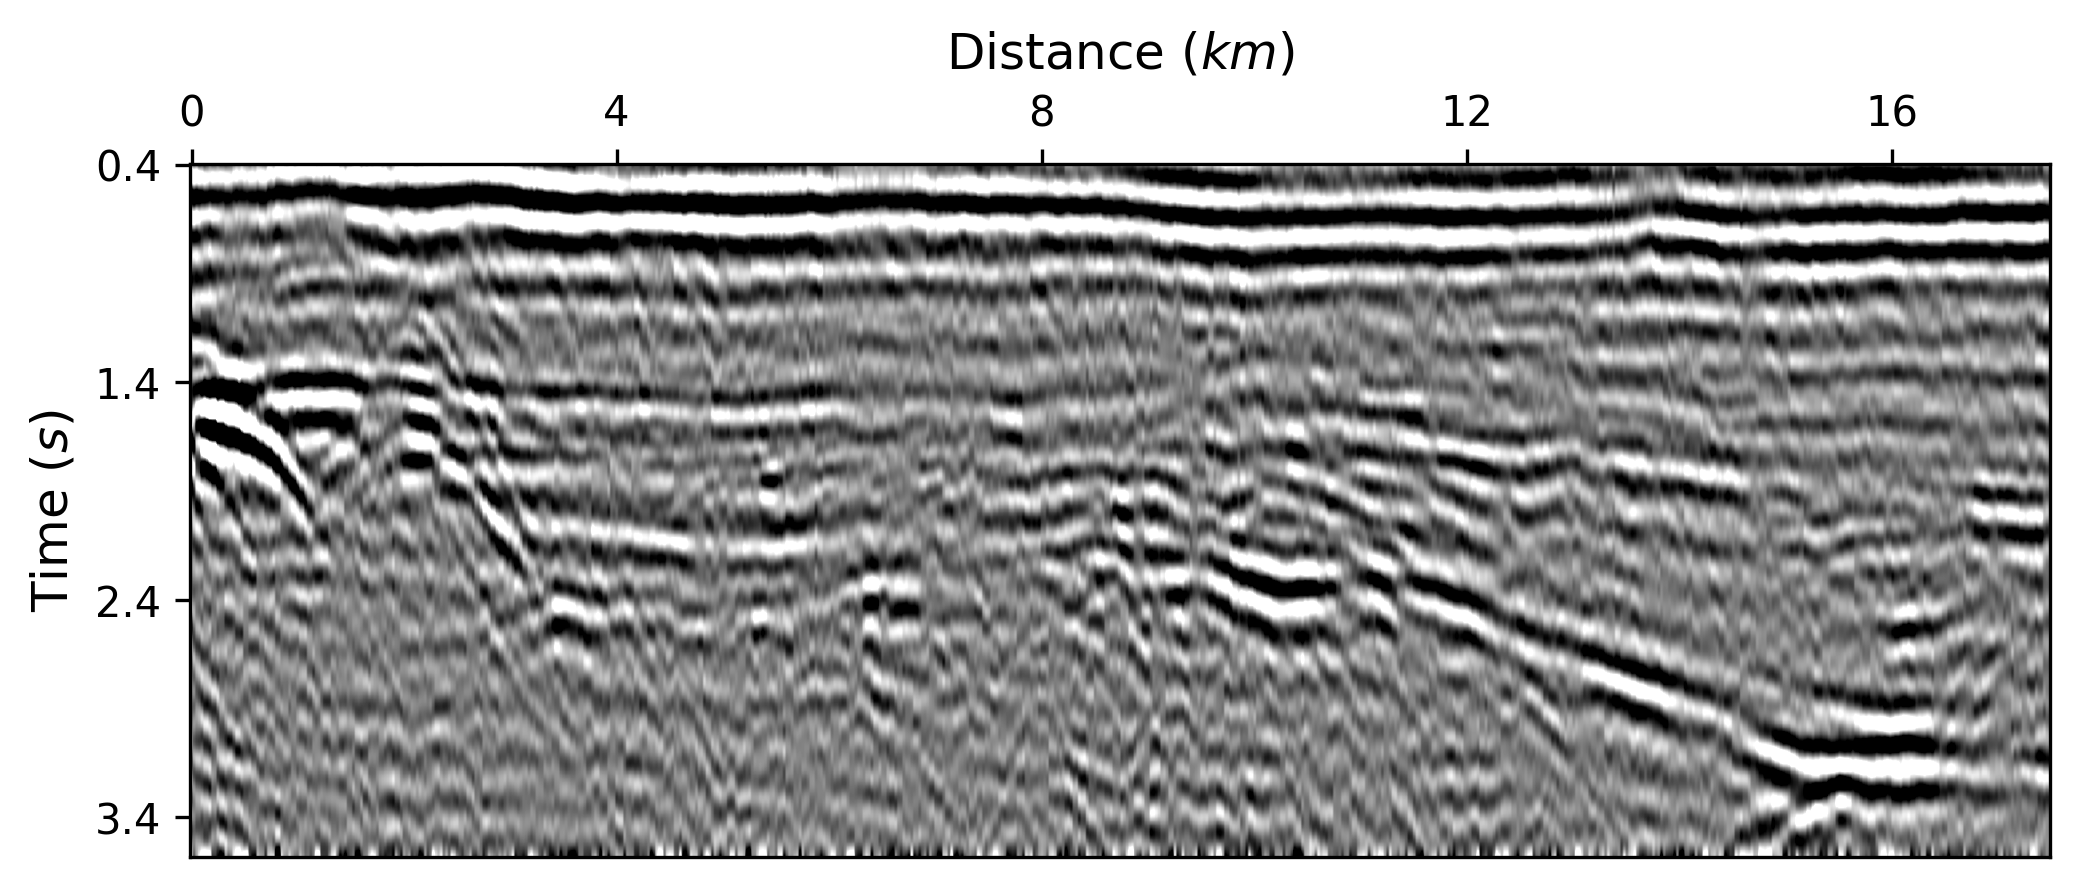

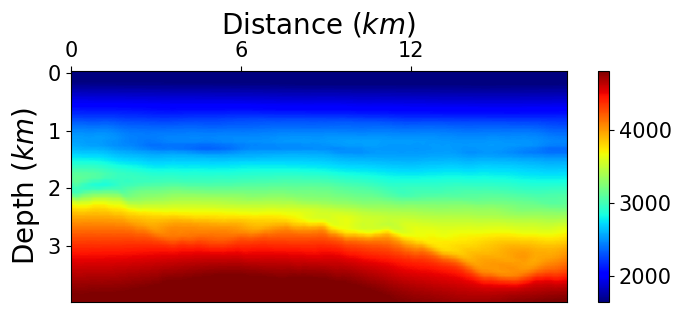

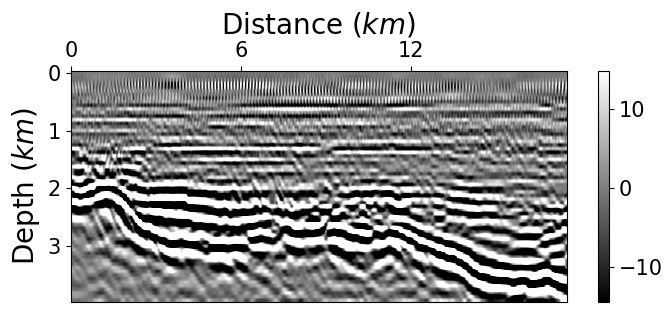

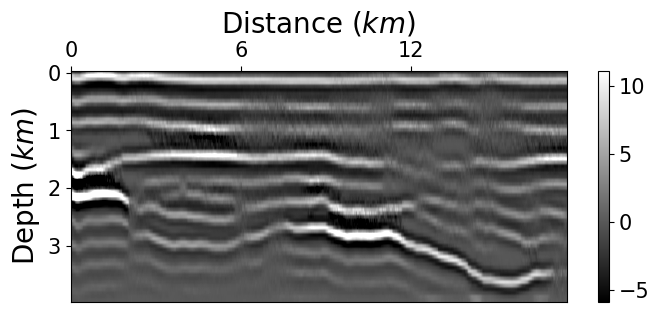

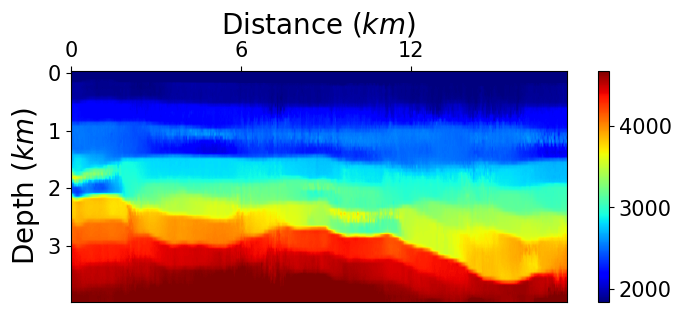

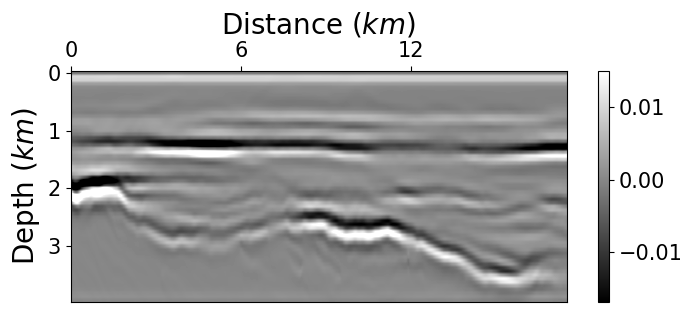

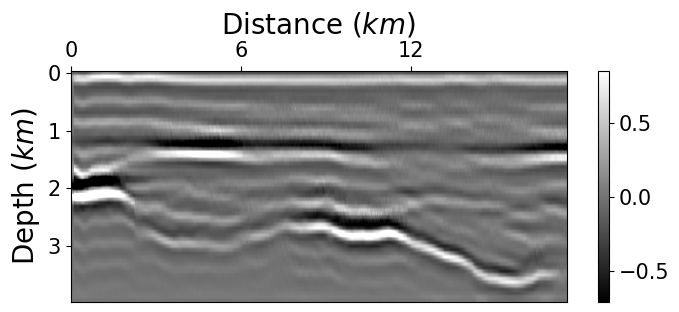

In [19]:
dt=2e-3

scal_trace=7
# scal_trace=11

import scipy.ndimage

rtm_i_resize_filter=scipy.ndimage.filters.gaussian_filter(rtm_i_resize, sigma=1)


rtm_i_resize_filter = scipy.ndimage.laplace(rtm_i_resize_filter)


vmin,vmax=np.percentile(cmp_i[n_channel:scal_trace*100+n_channel,0,:],[5,95]) 
plot_field_cmp(cmp_i[n_channel:scal_trace*100+n_channel,0,:],colorbar=1,vmin=vmin,vmax=vmax,cmap='gray')
vmin,vmax=np.percentile(cmp_i[n_channel:scal_trace*100+n_channel,0,:],[5,95]) 
plot_field_cmp(cmp_i[n_channel:scal_trace*100+n_channel,0,:],vmin=vmin,vmax=vmax,cmap='gray')
vmin,vmax=np.percentile(vp_real_i_resize[n_channel:scal_trace*100+n_channel,:],[5,95]) 
plot_data_img(vp_real_i_resize[n_channel:scal_trace*100+n_channel,:],colorbar=1,vmin=vmin,vmax=vmax,cmap='jet')

vmin,vmax=np.percentile(rtm_i_resize_filter[n_channel:scal_trace*100+n_channel,:30],[5,95]) 
plot_data_img(rtm_i_resize_filter[n_channel:scal_trace*100+n_channel,:],colorbar=1,vmin=vmin,vmax=vmax,cmap='gray')

vmin,vmax=np.percentile(full_profile_mean[n_channel:scal_trace*100+n_channel,:30],[1,99]) 
plot_data_img(full_profile_mean[n_channel:scal_trace*100+n_channel,:],colorbar=1,vmin=vmin,vmax=vmax,cmap='gray')




vmin,vmax=np.percentile(full_profile_mean2[n_channel:scal_trace*100+n_channel,:],[5,95]) 
plot_data_img(full_profile_mean2[n_channel:scal_trace*100+n_channel,:],vmin=vmin,vmax=vmax,colorbar=1,cmap='jet')





vmin,vmax=np.percentile(rtm_i0[n_channel:scal_trace*100,:],[1,99]) 
plot_data_img(rtm_i0[n_channel:scal_trace*100+n_channel,:],colorbar=1,vmin=vmin,vmax=vmax,cmap='gray')

ronghe=rtm_i0[n_channel:scal_trace*100+n_channel,:]/rtm_i0[n_channel:scal_trace*100+n_channel,:].max()+full_profile_mean[:scal_trace*100,:]/full_profile_mean[:scal_trace*100,:].max()
vmin,vmax=np.percentile(ronghe,[1,99]) 
plot_data_img(ronghe,vmin=vmin,vmax=vmax,cmap='gray',colorbar=1)


